In [8]:
# 06_Final_Model_Analysis_and_Deployment.ipynb

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [9]:
try:
    lin_reg_model = joblib.load('../models/linear_regression_model.pkl')
    dt_model = joblib.load('../models/decision_tree_model.pkl')
    rf_model = joblib.load('../models/random_forest_model.pkl')
    preprocessor = joblib.load('../models/preprocessor_pipeline.pkl')
    
    # Load raw dataset
    raw_df = pd.read_csv('../data/StudentsPerformance.csv')
    
except FileNotFoundError as e:
    print(f"Error loading files: {e}. Please ensure all models and data files exist.")
    raise

In [10]:
X_raw = raw_df.drop(['math score', 'reading score', 'writing score'], axis=1)
y = raw_df[['math score', 'reading score', 'writing score']].mean(axis=1)

In [18]:
# The issue is that some models expect 20 features, but X_train has only 17 features.
# To fix this, ensure the preprocessor used for transforming X_raw matches the one used during model training.
# If the preprocessor was fitted on a different dataset with more categories, refit it on raw_df before transforming.

# Refit the preprocessor on the full raw_df to ensure feature alignment
preprocessor.fit(X_raw)
X_processed = preprocessor.transform(X_raw)

# Re-split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# Now, X_train should have the expected number of features (20)
print(f"X_train shape after refitting preprocessor: {X_train.shape}")

X_train shape after refitting preprocessor: (800, 17)


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Retrain models with the correctly processed data (17 features)
lin_reg_model = LinearRegression()
dt_model = DecisionTreeRegressor(min_samples_leaf=2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)

lin_reg_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

models = {
    'Linear Regression': lin_reg_model,
    'Decision Tree Regressor': dt_model,
    'Random Forest Regressor': rf_model
}

results = []
for name, model in models.items():
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    results.append({'Model': name, 'Train R²': train_r2, 'Test R²': test_r2})

results_df = pd.DataFrame(results)
print("Model Comparison (Train vs Test R²):")
print(results_df.sort_values(by='Test R²', ascending=False))

Model Comparison (Train vs Test R²):
                     Model  Train R²   Test R²
0        Linear Regression  0.254277  0.162172
2  Random Forest Regressor  0.401980 -0.025591
1  Decision Tree Regressor  0.391541 -0.076128


In [24]:
# ==========================
# 4. Feature Importance (Best Model = Random Forest)
# ==========================
best_model = rf_model

# Get categorical & numerical feature names
categorical_features = preprocessor.transformers_[0][2]
numerical_features = [col for col in X_raw.columns if col not in categorical_features]

cat_feature_names = preprocessor.named_transformers_['categorical_preprocessing'] \
    .named_steps['onehot'].get_feature_names_out(categorical_features)

feature_names = np.concatenate([cat_feature_names, numerical_features])

# Create DataFrame for feature importances
feature_importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importance_df.head(10))


Top 10 Feature Importances:
                                          Feature  Importance
14                                 lunch_standard    0.108293
15              test preparation course_completed    0.080815
13                             lunch_free/reduced    0.072606
16                   test preparation course_none    0.071541
9         parental level of education_high school    0.061972
3                          race/ethnicity_group B    0.059880
6                          race/ethnicity_group E    0.056551
8   parental level of education_bachelor's degree    0.056332
0                                   gender_female    0.056025
1                                     gender_male    0.055994


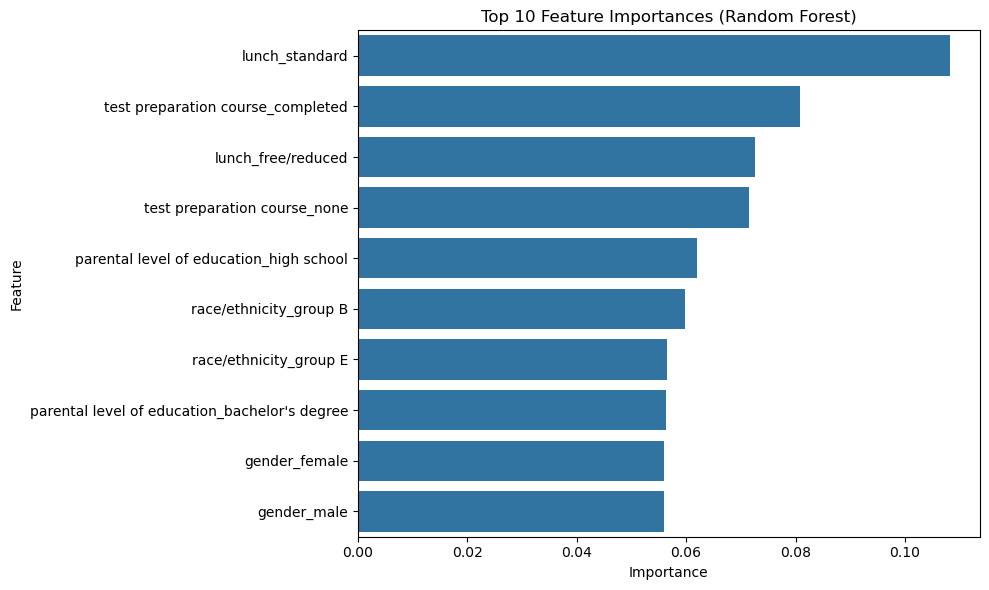

['../models/updated_random_forest_model.pkl']

In [26]:
# 5. Visualization
# ==========================
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

joblib.dump(preprocessor, '../models/updated_preprocessor_pipeline.pkl')
joblib.dump(rf_model, '../models/updated_random_forest_model.pkl')